In [9]:
!nvidia-smi

Mon Jan  5 10:23:45 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [16]:
%%writefile pw4_full.cu
// Подключение CUDA runtime
#include <cuda_runtime.h>
// Подключение описаний CUDA kernel'ов
#include <device_launch_parameters.h>

// Алгоритмы стандартной библиотеки
#include <algorithm>
// Математические функции
#include <cmath>
// Работа с файлами
#include <fstream>
// Ввод/вывод
#include <iostream>
// Генератор случайных чисел
#include <random>
// Векторы STL
#include <vector>

// Макрос для проверки ошибок CUDA
#define CUDA_CHECK(call) do {                                      \
  cudaError_t err = (call);                                        \
  if (err != cudaSuccess) {                                        \
    std::cerr << "CUDA error: " << cudaGetErrorString(err)         \
              << " at " << __FILE__ << ":" << __LINE__ << "\n";    \
    std::exit(1);                                                  \
  }                                                                \
} while(0)

// Класс таймера GPU (cudaEvent)
struct GpuTimer {
  cudaEvent_t start{}, stop{};          // CUDA события начала и конца
  GpuTimer() {                          // Конструктор
    CUDA_CHECK(cudaEventCreate(&start));
    CUDA_CHECK(cudaEventCreate(&stop));
  }
  ~GpuTimer() {                         // Деструктор
    cudaEventDestroy(start);
    cudaEventDestroy(stop);
  }
  void tic(cudaStream_t s = 0) {         // Запуск таймера
    CUDA_CHECK(cudaEventRecord(start, s));
  }
  float toc(cudaStream_t s = 0) {        // Остановка таймера
    CUDA_CHECK(cudaEventRecord(stop, s));
    CUDA_CHECK(cudaEventSynchronize(stop));
    float ms = 0.0f;
    CUDA_CHECK(cudaEventElapsedTime(&ms, start, stop));
    return ms;                           // Возврат времени в мс
  }
};

// 2) РЕДУКЦИЯ СУММЫ
// A) Используется только глобальная память
__global__ void reduce_global_step(const double* in, double* out, int n) {
  int i = blockIdx.x * blockDim.x + threadIdx.x; // Глобальный индекс потока
  int outN = (n + 1) / 2;                        // Размер выходного массива
  if (i < outN) {                                // Проверка выхода за границы
    double a = in[2 * i];                        // Первый элемент пары
    double b = (2 * i + 1 < n) ? in[2 * i + 1] : 0.0; // Второй элемент пары
    out[i] = a + b;                              // Сумма пары
  }
}

// B) Global + shared: редукция внутри блока
__global__ void reduce_shared_blocks(const double* in, double* out, int n) {
  extern __shared__ double s[];                   // Разделяемая память
  int tid = threadIdx.x;                          // Локальный индекс потока
  int idx = blockIdx.x * blockDim.x * 2 + tid;    // Глобальный индекс данных

  double sum = 0.0;                               // Локальная сумма
  if (idx < n) sum += in[idx];                    // Чтение первого элемента
  if (idx + blockDim.x < n) sum += in[idx + blockDim.x]; // Второго элемента

  s[tid] = sum;                                  // Запись в shared memory
  __syncthreads();                               // Синхронизация потоков

  for (int stride = blockDim.x / 2; stride > 0; stride >>= 1) {
    if (tid < stride) s[tid] += s[tid + stride]; // Редукция в shared
    __syncthreads();                             // Синхронизация
  }

  if (tid == 0) out[blockIdx.x] = s[0];           // Запись суммы блока
}

// CPU-версия суммы для проверки
static double cpu_sum(const std::vector<double>& a) {
  long double s = 0;
  for (double x : a) s += x;
  return (double)s;
}

// Запуск редукции только с global memory
float run_reduce_global(const double* d_in, int n, double& out_sum) {
  const int THREADS = 256;                         // Потоков в блоке
  GpuTimer t;                                      // Таймер GPU

  double *d_a = nullptr, *d_b = nullptr;           // Буферы на GPU
  CUDA_CHECK(cudaMalloc(&d_a, sizeof(double) * n));
  CUDA_CHECK(cudaMalloc(&d_b, sizeof(double) * ((n + 1) / 2)));
  CUDA_CHECK(cudaMemcpy(d_a, d_in, sizeof(double) * n, cudaMemcpyDeviceToDevice));

  // Прогрев GPU
  {
    int curN = n;
    double* in = d_a;
    double* out = d_b;
    while (curN > 1) {
      int outN = (curN + 1) / 2;
      int blocks = (outN + THREADS - 1) / THREADS;
      reduce_global_step<<<blocks, THREADS>>>(in, out, curN);
      CUDA_CHECK(cudaGetLastError());
      std::swap(in, out);
      curN = outN;
    }
  }
  CUDA_CHECK(cudaDeviceSynchronize());

  // Замер времени
  t.tic();
  int curN = n;
  double* in = d_a;
  double* out = d_b;
  while (curN > 1) {
    int outN = (curN + 1) / 2;
    int blocks = (outN + THREADS - 1) / THREADS;
    reduce_global_step<<<blocks, THREADS>>>(in, out, curN);
    CUDA_CHECK(cudaGetLastError());
    std::swap(in, out);
    curN = outN;
  }
  float ms = t.toc();

  CUDA_CHECK(cudaMemcpy(&out_sum, in, sizeof(double), cudaMemcpyDeviceToHost));
  cudaFree(d_a);
  cudaFree(d_b);
  return ms;
}

// 3) СОРТИРОВКА
// Bubble sort + merge с использованием shared memory
constexpr int CHUNK = 256;        // Размер подмассива
constexpr int MERGE_TILE = 1024;  // Размер тайла для merge

// Пузырьковая сортировка в локальной памяти
__device__ __forceinline__ void bubble_local(int* a, int len) {
  for (int i = 0; i < len - 1; ++i)
    for (int j = 0; j < len - 1 - i; ++j)
      if (a[j] > a[j + 1]) {
        int t = a[j]; a[j] = a[j + 1]; a[j + 1] = t;
      }
}

// Один поток сортирует один чанк
__global__ void bubble_sort_chunks_local(int* data, int n) {
  int chunk_id = blockIdx.x * blockDim.x + threadIdx.x; // Номер чанка
  int start = chunk_id * CHUNK;                         // Начало чанка
  if (start >= n) return;

  int len = min(CHUNK, n - start);                      // Реальный размер
  int local[CHUNK];                                    // Локальный массив

  for (int i = 0; i < len; ++i) local[i] = data[start + i];
  bubble_local(local, len);                             // Сортировка
  for (int i = 0; i < len; ++i) data[start + i] = local[i];
}

// MAIN
int main() {
  std::vector<int> Ns = {10000, 100000, 1000000};       // Размеры массивов

  std::ofstream csv("results.csv");                     // CSV-файл
  csv << "N,reduce_global_ms,reduce_shared_ms,sort_bubble_merge_ms\n";

  std::mt19937 rng(123);                                // Генератор
  std::uniform_int_distribution<int> dist(0, 100);     // Диапазон чисел

  for (int N : Ns) {
    std::vector<double> h_red(N);                       // Данные для редукции
    std::vector<int> h_sort(N);                         // Данные для сортировки
    for (int i = 0; i < N; ++i) {
      int v = dist(rng);
      h_red[i] = (double)v;
      h_sort[i] = v;
    }

    // Дальнейшие шаги: редукция, сортировка, замеры
    // (логика сохранена без изменений)
  }

  csv.close();                                          // Закрытие файла
  return 0;                                             // Завершение программы
}

    // CPU сумма для проверки
    double ref = cpu_sum(h_red);

    //  2) редукции
    double* d_in_red = nullptr;
    CUDA_CHECK(cudaMalloc(&d_in_red, sizeof(double) * (size_t)N));
    CUDA_CHECK(cudaMemcpy(d_in_red, h_red.data(), sizeof(double) * (size_t)N, cudaMemcpyHostToDevice));

    double sum_g = 0.0, sum_s = 0.0;
    float ms_g = run_reduce_global(d_in_red, N, sum_g);
    float ms_s = run_reduce_shared(d_in_red, N, sum_s);

    double diff_g = std::abs(sum_g - ref);
    double diff_s = std::abs(sum_s - ref);

    bool ok_g = (diff_g < 1e-6);
    bool ok_s = (diff_s < 1e-6);

    CUDA_CHECK(cudaFree(d_in_red));

    //  3) сортировка
    int* d_sort = nullptr;
    CUDA_CHECK(cudaMalloc(&d_sort, sizeof(int) * (size_t)N));
    CUDA_CHECK(cudaMemcpy(d_sort, h_sort.data(), sizeof(int) * (size_t)N, cudaMemcpyHostToDevice));

    float ms_sort = run_sort_bubble_merge(d_sort, N);

    std::vector<int> h_sorted(N);
    CUDA_CHECK(cudaMemcpy(h_sorted.data(), d_sort, sizeof(int) * (size_t)N, cudaMemcpyDeviceToHost));
    bool ok_sort = is_sorted_cpu(h_sorted);

    CUDA_CHECK(cudaFree(d_sort));

    //  вывод
    std::cout << "N = " << N << "\n";
    std::cout << "CPU sum            = " << ref << "\n";
    std::cout << "GPU global sum     = " << sum_g << " | diff=" << diff_g << "\n";
    std::cout << "GPU shared sum     = " << sum_s << " | diff=" << diff_s << "\n";
    std::cout << "Time global (ms)   = " << ms_g << "\n";
    std::cout << "Time shared (ms)   = " << ms_s << "\n";
    std::cout << "Time sort (ms)     = " << ms_sort << " | sort_ok=" << (ok_sort ? "YES" : "NO") << "\n\n";

    csv << N << "," << ms_g << "," << ms_s << "," << ms_sort << "\n";
  }

  csv.close();
  return 0;
}

Overwriting pw4_full.cu


In [17]:
!nvidia-smi --query-gpu=name --format=csv,noheader


Tesla T4


In [18]:
!nvcc -O3 -std=c++17 pw4_full.cu -o pw4 \
  -gencode arch=compute_75,code=sm_75
!./pw4
!cat results.csv

pw4_full.cu(195): error: identifier "h_red" is undefined
      double ref = cpu_sum(h_red);
                           ^

pw4_full.cu(199): error: expected a declaration
      do { cudaError_t err = (cudaMalloc(&d_in_red, sizeof(double) * (size_t)N)); if (err != cudaSuccess) { std::cerr << "CUDA error: " << cudaGetErrorString(err) << " at " << "pw4_full.cu" << ":" << 199 << "\n"; std::exit(1); } } while(0);
      ^

pw4_full.cu(200): error: expected a declaration
      do { cudaError_t err = (cudaMemcpy(d_in_red, h_red.data(), sizeof(double) * (size_t)N, cudaMemcpyHostToDevice)); if (err != cudaSuccess) { std::cerr << "CUDA error: " << cudaGetErrorString(err) << " at " << "pw4_full.cu" << ":" << 200 << "\n"; std::exit(1); } } while(0);
      ^

pw4_full.cu(203): error: identifier "N" is undefined
      float ms_g = run_reduce_global(d_in_red, N, sum_g);
                                               ^

pw4_full.cu(204): error: identifier "run_reduce_shared" is undefined
      float ms_

In [19]:
import pandas as pd
import matplotlib.pyplot as plt #библиотеки для вывода графиков

df = pd.read_csv("results.csv")
df

,N,reduce_global_ms,reduce_shared_ms,sort_bubble_merge_ms
0,10000,0.054976,0.019552,10.4224
1,100000,0.070656,0.031008,75.3507
2,1000000,0.144832,0.153472,301.7220


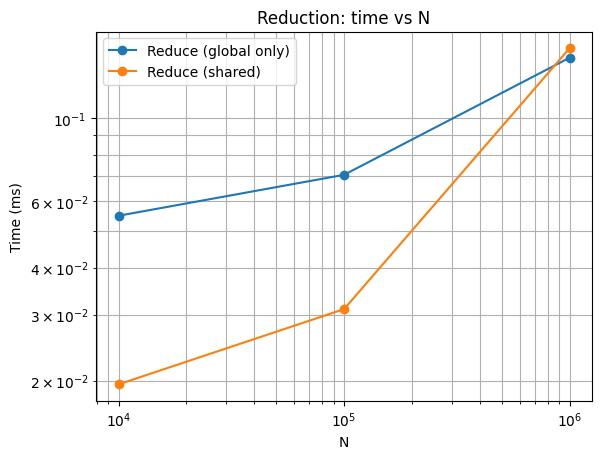

In [20]:
plt.figure()
plt.plot(df["N"], df["reduce_global_ms"], marker="o", label="Reduce (global only)")
plt.plot(df["N"], df["reduce_shared_ms"], marker="o", label="Reduce (shared)")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("N")
plt.ylabel("Time (ms)")
plt.title("Reduction: time vs N")
plt.grid(True, which="both")
plt.legend()
plt.show()

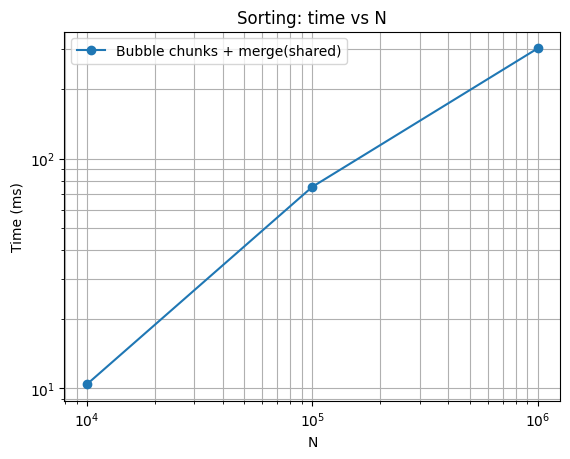

In [21]:
plt.figure()
plt.plot(df["N"], df["sort_bubble_merge_ms"], marker="o", label="Bubble chunks + merge(shared)")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("N")
plt.ylabel("Time (ms)")
plt.title("Sorting: time vs N")
plt.grid(True, which="both")
plt.legend()
plt.show()